In [231]:
# Required Libraries
import numpy as np
import h5py
import ncempy
import py4DSTEM
import hyperspy.api as hs
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
print('py4DSTEM: {}'.format(py4DSTEM.__version__))
import pandas as pd

py4DSTEM: 0.13.6


## Convert data file 

In [237]:
file_path_data = r'D:\\Documents\Research\Anaconda_Starting_Folder\09132022-4dstem HEA\probe 400kx\probe_400kx.dm4'
dataset = py4DSTEM.io.import_file(file_path_data)
save_path_data = r'D:\\Documents\Research\Anaconda_Starting_Folder\09132022-4dstem HEA\probe 400kx\probe_400kx.h5'
py4DSTEM.save(filepath=save_path_data,data=dataset)

# create probe file

In [ ]:
dataset_probe_tile = np.tile(dataset_probe.data,(5,5,1,1))
dataset_probe_datacube = py4DSTEM.io.datastructure.datacube.DataCube(dataset_probe_tile)
save_path_data = r'D:\\Documents\Research\Anaconda_Starting_Folder\09022022-4dstem_HEA\HEA[110]\probe_processed.h5'
py4DSTEM.save(filepath=save_path_data,data=dataset_probe_datacube)

# Load data

In [528]:
#Load the datacubes using py4DSTEM
file_path_data = r'D:\Documents\Research\Anaconda_Starting_Folder\09132022-4dstem HEA\SI data (50)_400kx\HEA_400kx.h5'
file_path_probe = r'D:\Documents\Research\Anaconda_Starting_Folder\09132022-4dstem HEA\probe 400kx\probe_400kx.h5'
file_path_analysis = r'D:\Documents\Research\Anaconda_Starting_Folder\09132022-4dstem HEA\SI data (50)_400kx\HEA_analysis_'

In [493]:
dataset = py4DSTEM.read(file_path_data)['dm_dataset']   # data

In [494]:
dataset_probe = py4DSTEM.read(file_path_probe)['dm_dataset']  # vacuum probe

In [495]:
# swap the real space and reciprocal space because of dm4 format
dataset.data = np.moveaxis(dataset.data,[0,1,2,3],[2,3,0,1])
dataset_probe.data = np.moveaxis(dataset_probe.data,[0,1,2,3],[2,3,0,1])

In [496]:
dataset.data.shape

(120, 120, 512, 512)

In [497]:
# crop data set to 100*100 pixel
dataset.data = dataset.data[40:120,0:120,:,:]

In [498]:
dataset.data.shape

(80, 120, 512, 512)

# Examine the data 

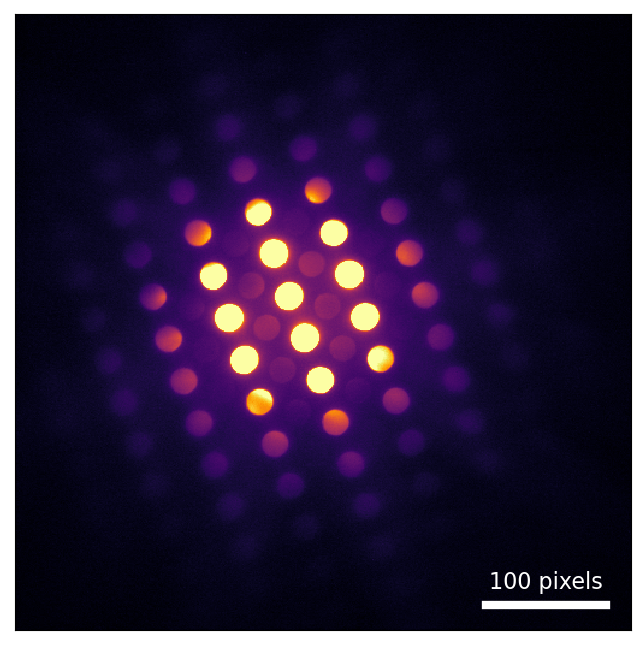

In [499]:
# Plot the mean diffraction pattern
dataset.get_dp_mean();

py4DSTEM.show(
    dataset.tree['dp_mean'],
    clipvals='manual',
    min = 0,
    max = 5e3,
    cmap='inferno'
)

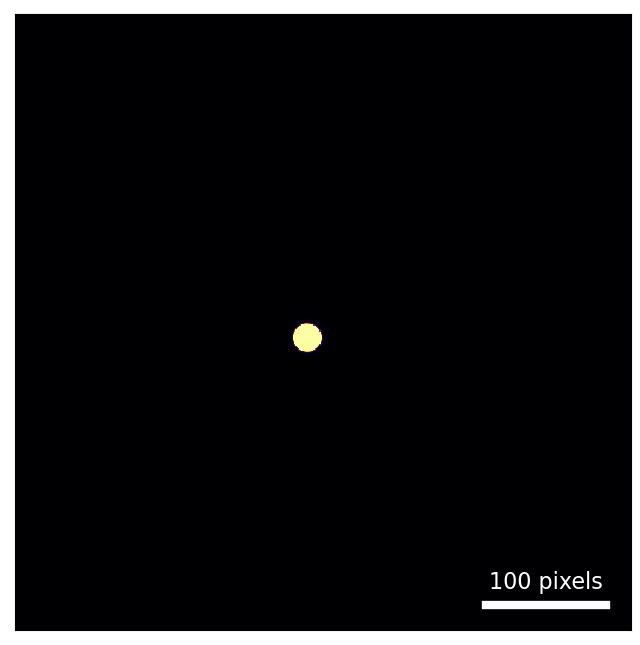

In [500]:
# Generate the mean probe
dataset_probe.get_dp_mean();

# Plot the mean Probe
py4DSTEM.show(
    dataset_probe.tree['dp_mean'],
    clipvals = 'manual',
    min = 0.0,
    max = 50e3,
    cmap = 'inferno',
)


# use transmitted beam for vacuum probe

In [501]:
# test_probe = dataset.get_vacuum_probe(ROI = (7,10,7,10), mask_threshold=0.25)
# plt.imshow(test_probe.probe)
# dataset_probe_tile = np.tile(test_probe.probe,(5,5,1,1))
# dataset_probe_datacube = py4DSTEM.io.datastructure.datacube.DataCube(dataset_probe_tile)
# save_path_data = r'D:\\Documents\Research\Anaconda_Starting_Folder\09022022-4dstem_HEA\HEA[110]\probe_processed.h5'
# py4DSTEM.save(filepath=save_path_data,data=dataset_probe_datacube)

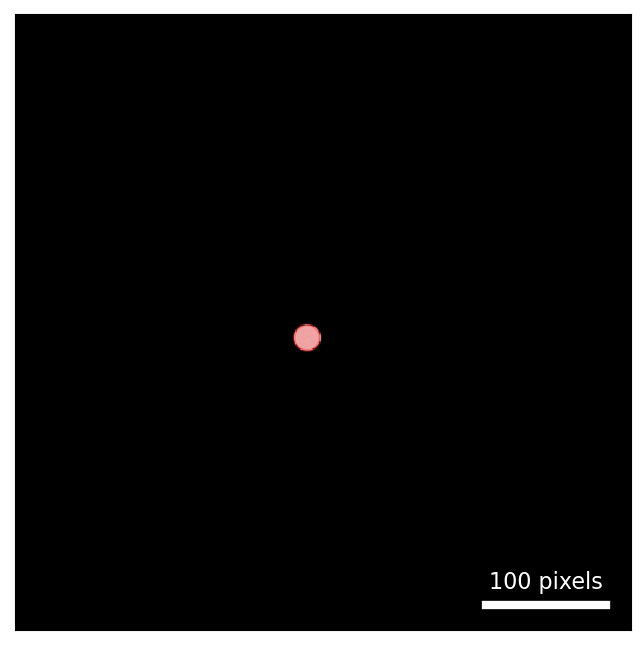

Estimated probe radius = 10.68 pixels


In [502]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset_probe.get_probe_size()


# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    dataset_probe.tree['dp_mean'], 
    (probe_qx0, probe_qy0), 
    probe_semiangle,
)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [503]:
# Next, create a BF virtual detector using the center beam position (qx0, qy0), and a virtual DF detector.
# The DF virtual detector can be set to all remaining pixels.

expand_BF = 5.0

center = (probe_qx0, probe_qy0)
radius = probe_semiangle + expand_BF


dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',
)


radii = (probe_semiangle + expand_BF, 1e3)

dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
);

100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:46<00:00, 208.46it/s]


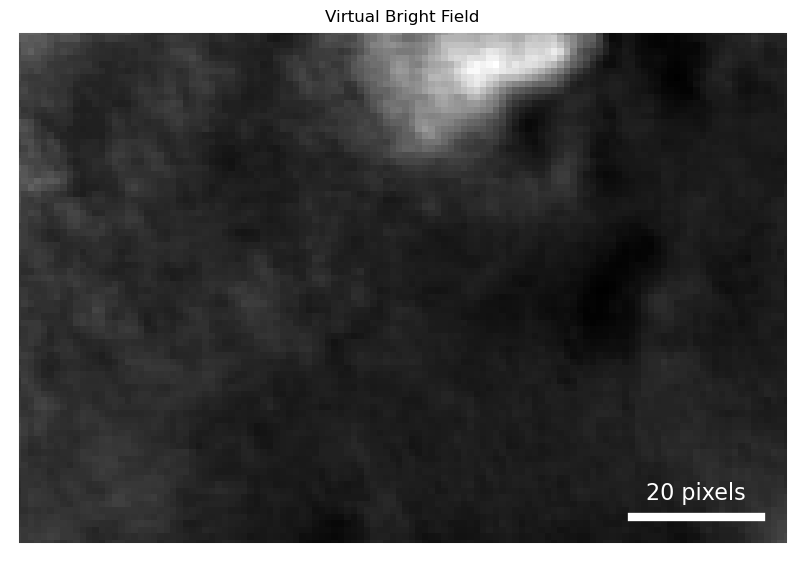

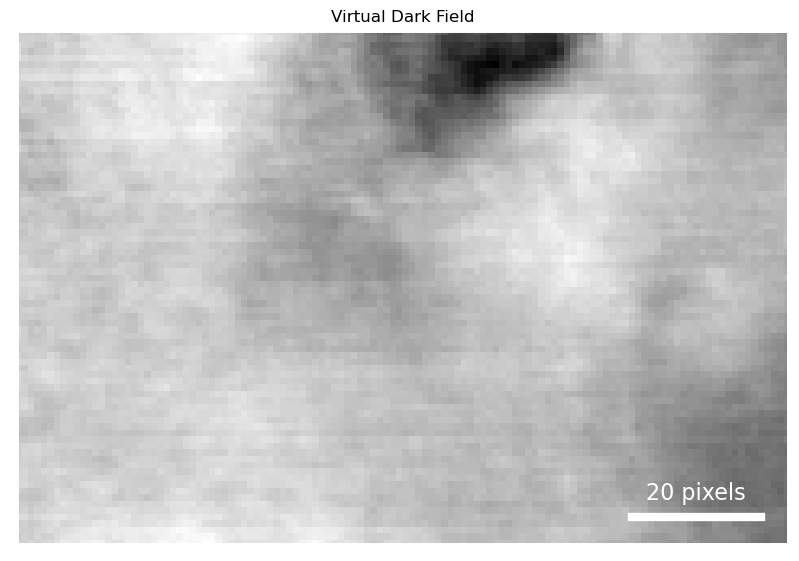

In [504]:
py4DSTEM.show(
    dataset.tree['bright_field'],
    figsize=(10,10),
    bordercolor = 'w',
    cmap='gray',
    title='Virtual Bright Field',
)
py4DSTEM.show(
    dataset.tree['dark_field'],
    figsize=(10,10),
    bordercolor = 'w',
    cmap = 'gray',
    title='Virtual Dark Field',
)

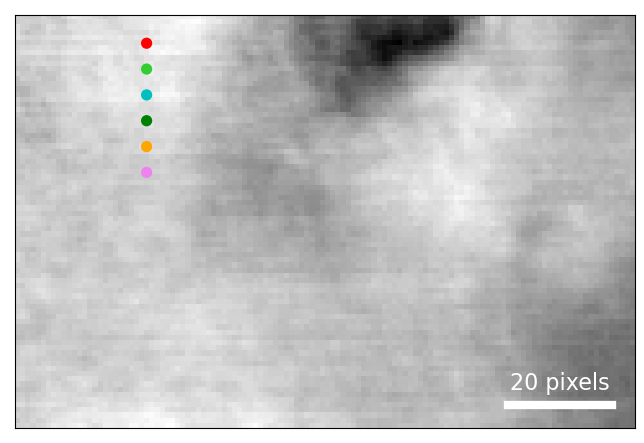

In [505]:
# Choose some diffraction patterns to use for hyperparameter tuning

rxs = 5, 10, 15, 20, 25, 30
rys = 25, 25, 25, 25, 25, 25
colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dataset.tree['dark_field'],
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Construct probe template

In [506]:
#probe = dataset.get_vacuum_probe(ROI = (0,2,0,2), mask_threshold=0.22)
probe = dataset_probe.get_vacuum_probe()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.56it/s]


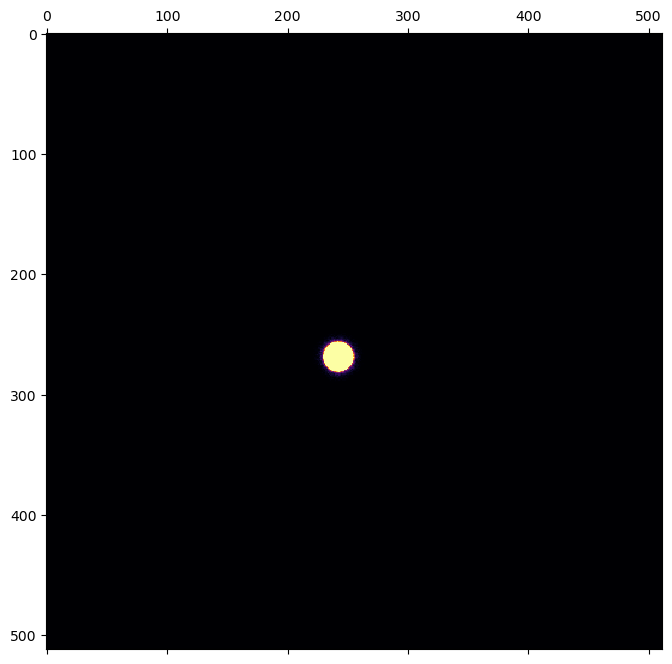

In [507]:
py4DSTEM.show(
    #probe.probe,
    dataset_probe.tree['probe'].probe,
    clipvals = 'manual',
    min = 0.0,
    max = 5e3,
    cmap='inferno',
)

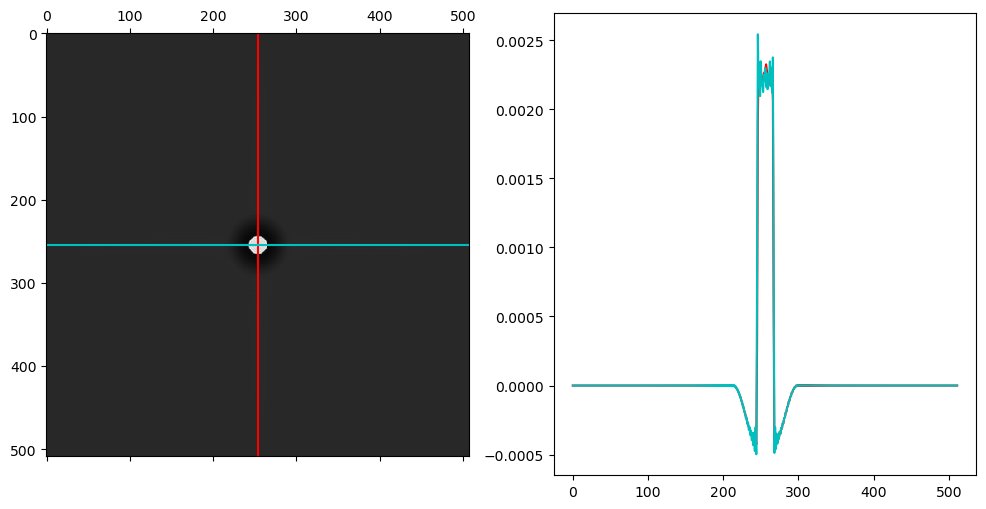

In [508]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 1.0, probe_semiangle * 4.0)
)

py4DSTEM.visualize.show_kernel(
    probe_kernel,
    R = 254,
    L = 256,
    W = 1
)

# Find Bragg Peaks

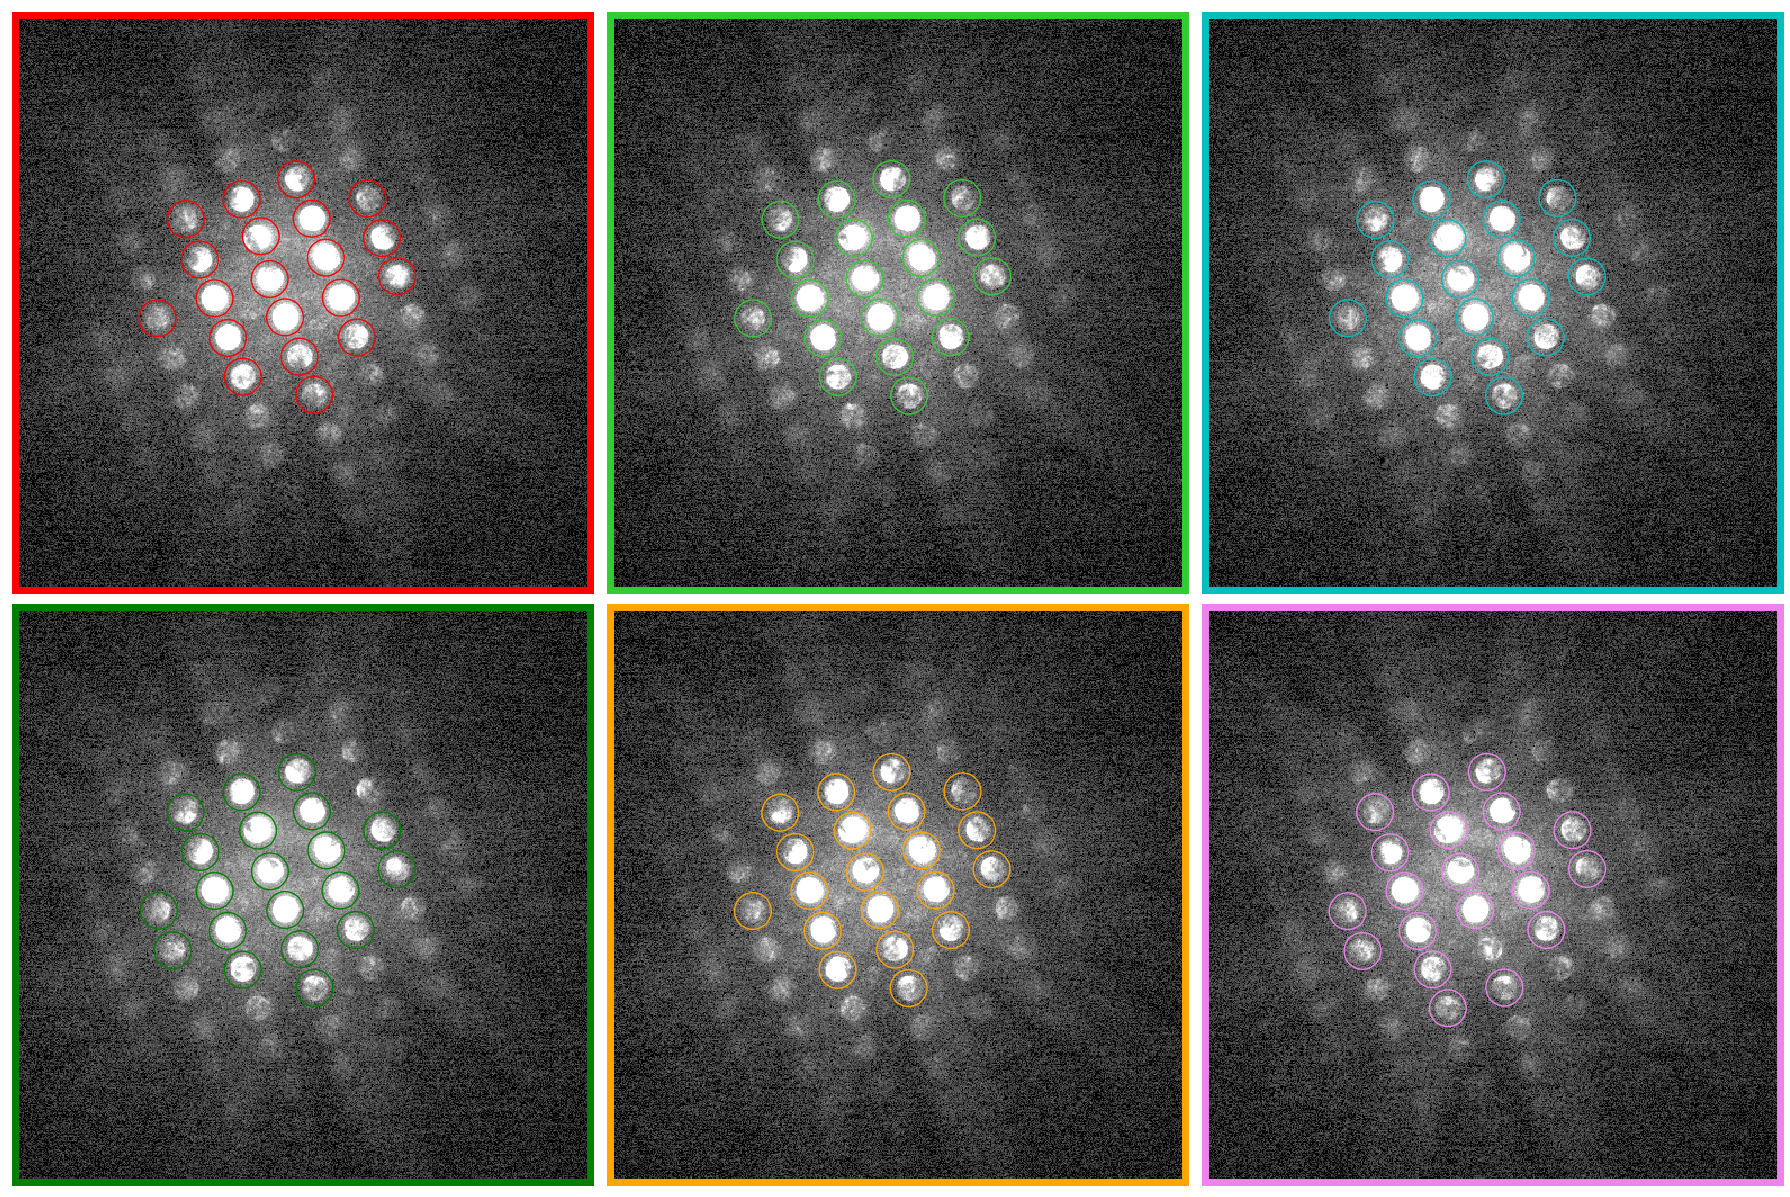

In [509]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions


# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 1,
    'edgeBoundary': 5,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1,
    'minPeakSpacing': 10,
    #'subpixel': 'poly',
    'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 20,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(6,6),
    clipvals='manual',
    vmin=0,
    vmax=5e3,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [510]:
# Find Bragg peaks in all probe positions.
# Note that "poly" subpixel fitting can be used to keep this tutoral fast, but "multicorr" is more accurate. 
# We strongly recommend the use of subpixel="multicorr" for strain mapping!

bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|████████████████████████████████████████████████████████| 9.60k/9.60k [15:36<00:00, 10.3DP/s]


# Save the peak data

In [511]:
# Save Bragg disk locations
file_name_braggdisks_raw = file_path_analysis + 'braggdisks_raw_80x120.h5'

In [512]:
# Save Bragg disk positions
py4DSTEM.save(
    file_name_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:04<00:00, 2038.53it/s]


# Load the peak data

In [529]:
# This step is optional, but can serve as a checkpoint in the analysis
#PbTe_file = r'D:\Documents\Research\Anaconda_Starting_Folder\09022022-4dstem_HEA\PbTe2\PbTe_analysis_braggdisks_raw_100x100.h5'
file_name_braggdisks_raw = file_path_analysis + 'braggdisks_raw_100x100.h5'
py4DSTEM.io.print_h5_tree(file_name_braggdisks_raw)

/
|--4DSTEM
	|--braggvectors
		|--_v_uncal
		|--calibration




In [530]:
bragg_peaks = py4DSTEM.read(
    file_name_braggdisks_raw, 
    root = '4DSTEM/braggvectors'
)
bragg_peaks

Reading PointListArray: 100%|███████████████████████████████████████████| 14400/14400 [00:02<00:00, 5307.57PointList/s]


BraggVectors( A (120, 120)-shaped array of lists of bragg vectors )

# Center coordinate system

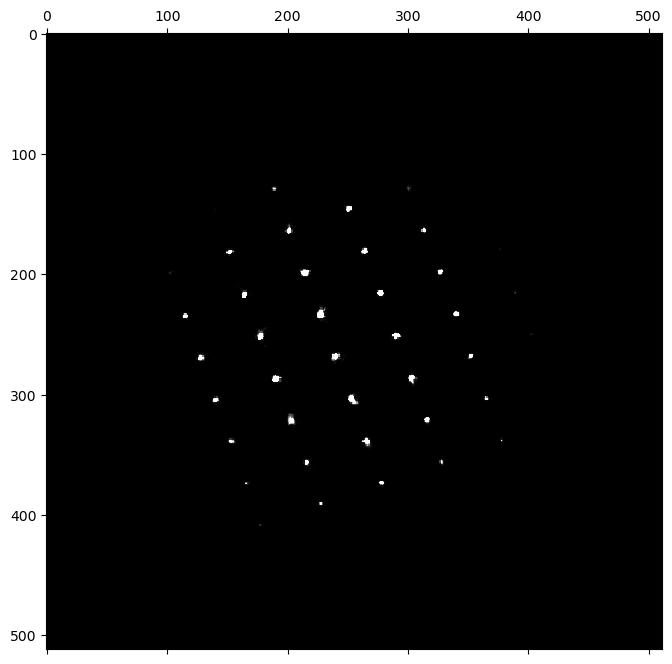

In [531]:
# Compute a Bragg vector map (BVM), a 2D histogram of the Bragg peak positions, weighted by their correlation intensities
bragg_peaks.get_bvm(mode = 'raw')

# Plot the BVM
bvm_vis_params = {
    'scaling':'power',
    'power':1,
    'clipvals':'manual',
    'vmin':0,
    'vmax':1e5,
}
py4DSTEM.show(
    bragg_peaks.bvm_raw,
    **bvm_vis_params,
    figsize=(8,8)
)

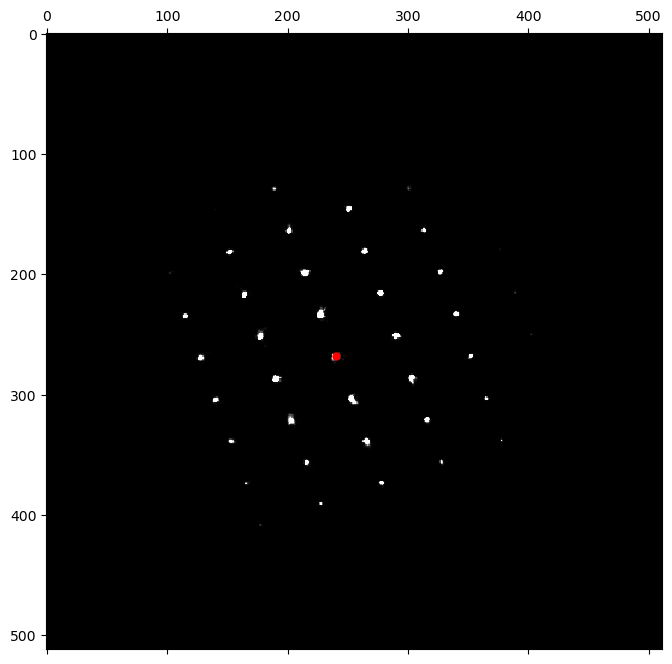

In [533]:
# Specify an annular region of Q-space 
center_guess = 268, 240#269, 242 


py4DSTEM.show(
    bragg_peaks.bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    **bvm_vis_params,
)

In [534]:
# Compute the origin position pattern-by-pattern 
origin_meas = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
    center_guess = center_guess,
)

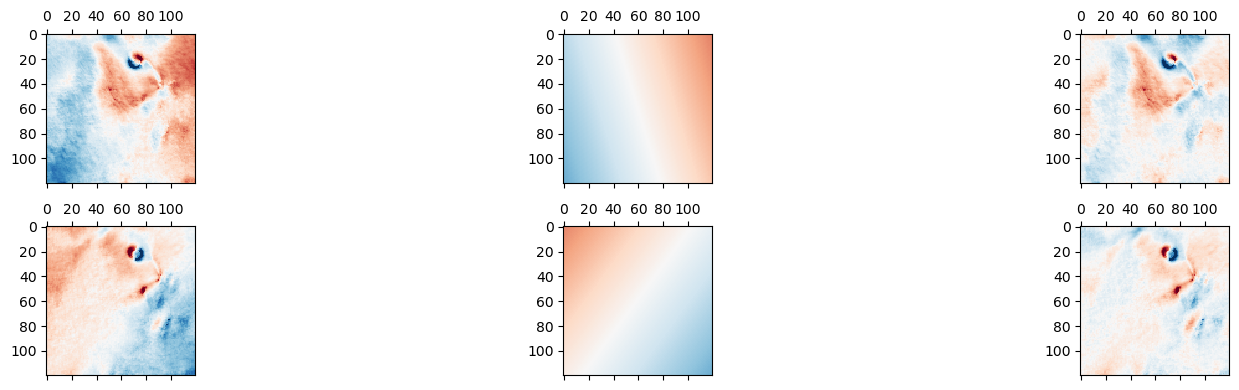

In [535]:
# Some local variation in the position of the origin due to electron-sample interaction is
# expected, and constitutes meaningful signal that we would not want to subtract away.
# In fitting a plane or parabolic surface to the measured origin shifts, we aim to
# capture the systematic shift of the beam due to the changing scan coils,
# while removing as little physically meaningful signal we can.

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

In [536]:
# Center the disk positions about the origin
bragg_peaks.calibrate()

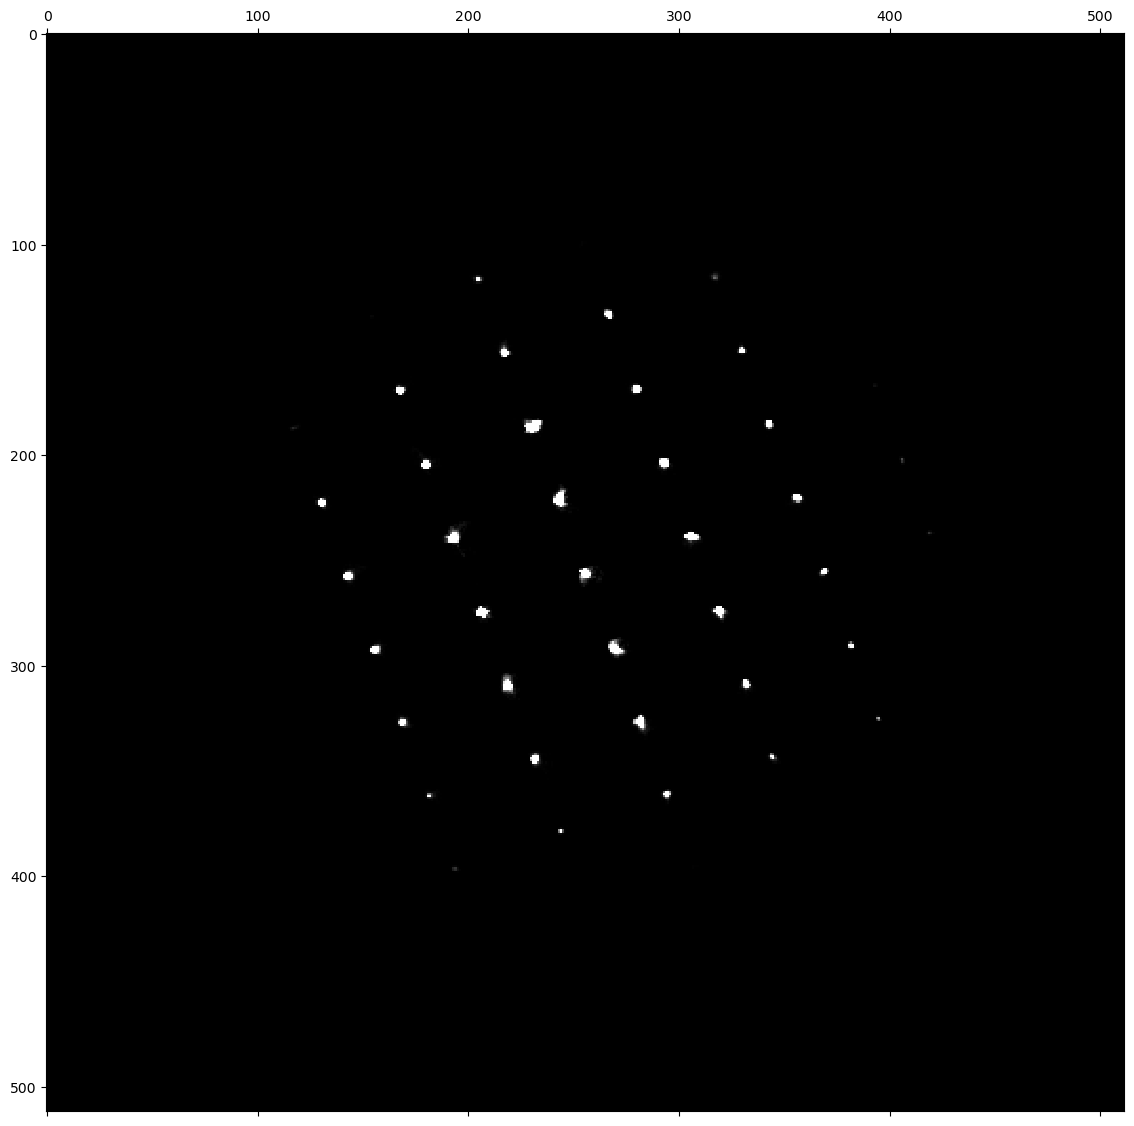

In [537]:
# Compute and plot the centered Bragg vector map

# Compute the Bragg vector map
bragg_peaks.get_bvm(mode = 'centered')

# plot the Bragg vector map
py4DSTEM.show(
    bragg_peaks.bvm_centered,
    figsize = (14,14),
    **bvm_vis_params,
)

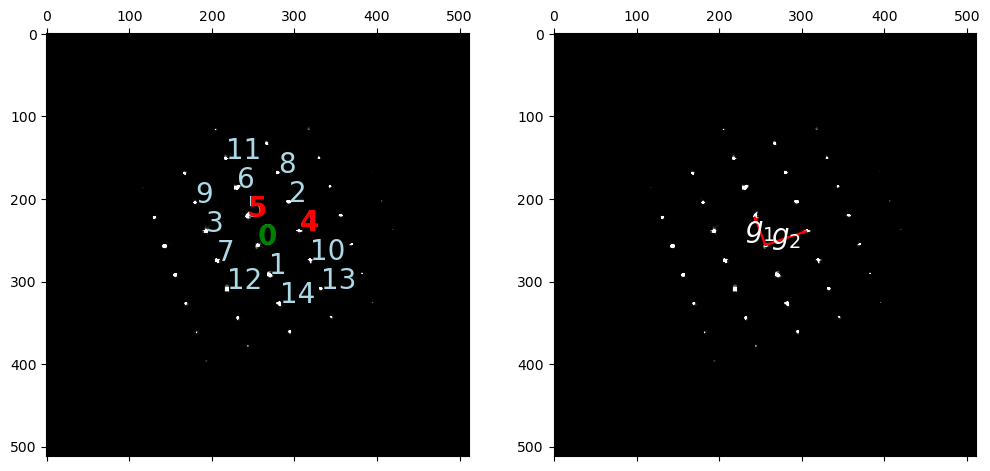

In [539]:
bragg_peaks.choose_lattice_vectors(
    0,
    5,
    4,
    sigma=0, 
    minSpacing=13,
    minAbsoluteIntensity=1e2,
    maxNumPeaks=15,
    subpixel='multicorr',
    bvm_vis_params = bvm_vis_params,
)

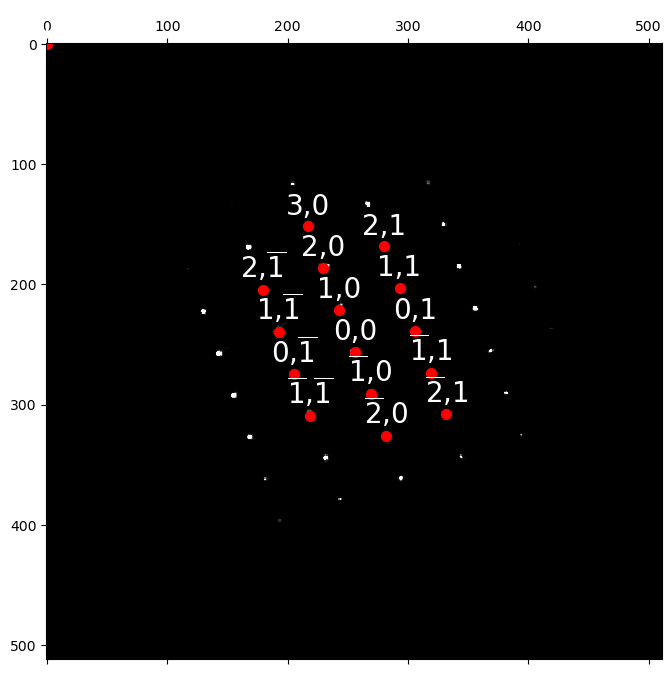

In [540]:
bragg_peaks.index_bragg_directions(bvm_vis_params = bvm_vis_params) # index based on g1 and g2 selection

In [541]:
# maximum peak spacing from expected positions
max_peak_spacing = 5

# add the lattice indices to all Bragg peaks
bragg_peaks.add_indices_to_braggpeaks(
    maxPeakSpacing = max_peak_spacing,
)

100%|██████████████████████████████████████████████████████████████████████████| 14400/14400 [00:02<00:00, 4989.01it/s]


In [542]:
# loop through all probe positions and find the best fit lattice
bragg_peaks.fit_lattice_vectors_all_DPs()

100%|██████████████████████████████████████████████████████████████████████████| 14400/14400 [00:03<00:00, 4245.89it/s]


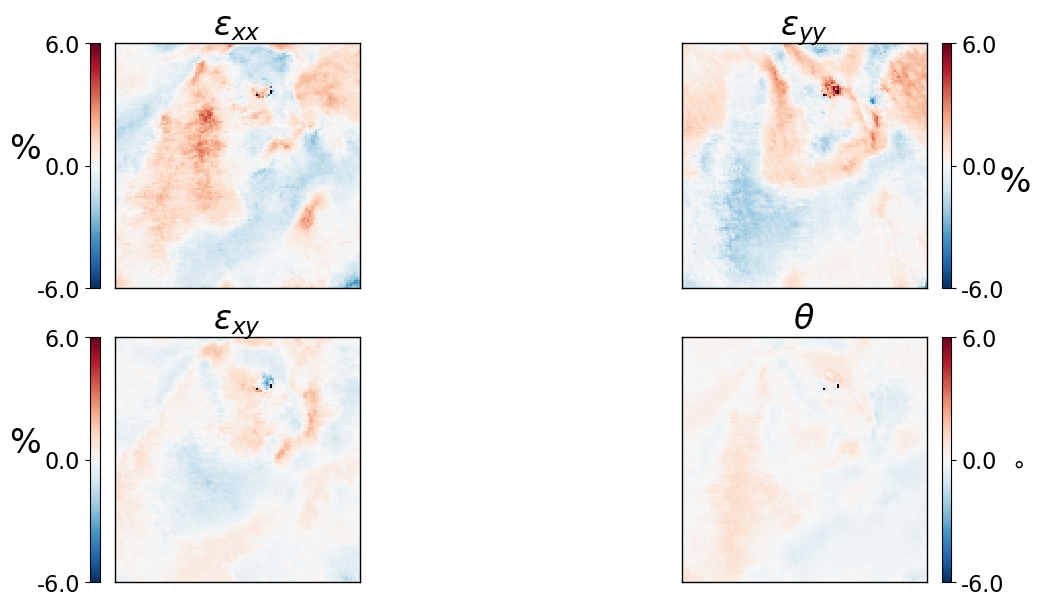

In [543]:
# To calculate strain, we need to find how lattice vector changes from a reference region.  # g1 vector is x direction and 90 deg from g1 is y

# Initially, we will define the reference region to be all pixels, and compute the strain
mask = np.ones((bragg_peaks.shape[0],bragg_peaks.shape[1]),dtype=bool)
bragg_peaks.get_strain_from_reference_region(mask = mask )

# Calculate the strain maps, referenced to the median lattice vectors of all probe positions
strainmap_median = bragg_peaks.get_rotated_strain_map(mode = 'median')

# plot the 4 components of the strain tensor
strain_fig = py4DSTEM.visualize.show_strain(
    strainmap_median,
    vrange_exx = [-6.0, 6.0],
    vrange_theta = [-6.0, 6.0],
    ticknumber = 3,
    axes_plots = (),
    bkgrd = False,
    figsize = (14,7),
    returnfig=True
)

# infinitesimal strain wikipedia

In [557]:
# To calculate strain, we need to find how lattice vector changes from a reference region.  # g1 vector is x direction and 90 deg from g1 is y

# Initially, we will define the reference region to be all pixels, and compute the strain
mask = np.ones((bragg_peaks.shape[0],bragg_peaks.shape[1]),dtype=bool)
bragg_peaks.get_strain_from_reference_region(mask = mask )

# Calculate the strain maps, referenced to the median lattice vectors of all probe positions
strainmap_median = bragg_peaks.get_rotated_strain_map(mode = 'median')



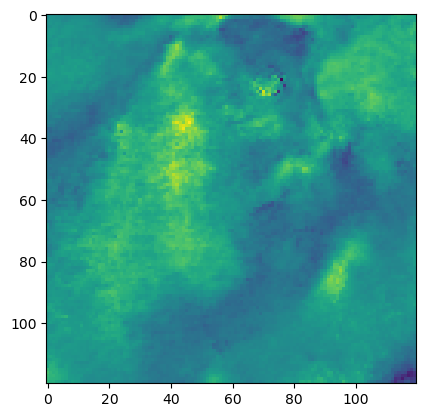

In [584]:
plt.imshow(strainmap_median[:,:,0])

Text(0.5, 1.0, 'Normalize()')

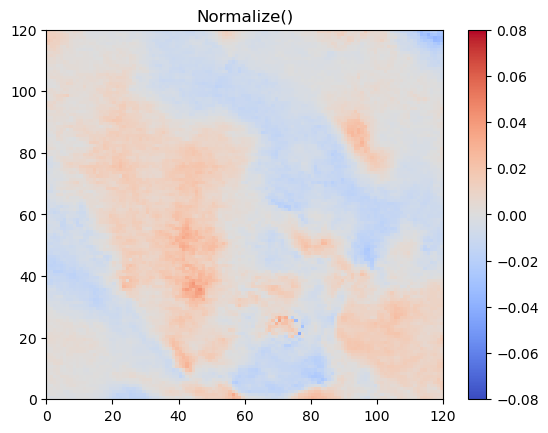

In [593]:
from matplotlib import cm
cmap = cm.coolwarm

fig, ax = plt.subplots()
pc = ax.pcolormesh(strainmap_median[:,:,0], vmax=0.08, vmin=-0.08,cmap=cmap)
fig.colorbar(pc, ax=ax)
ax.set_title('Normalize()')

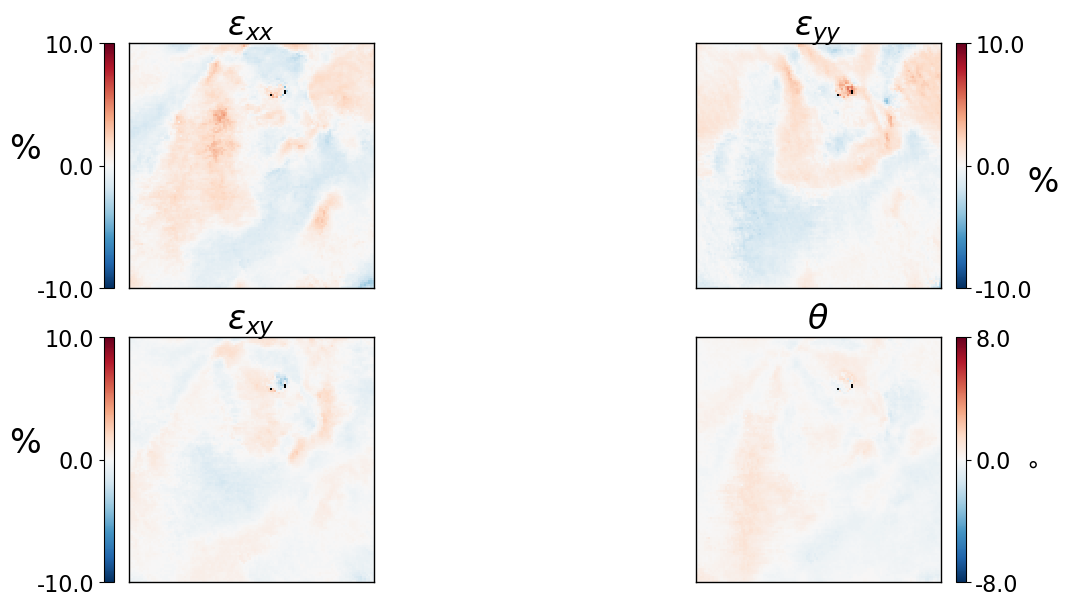

In [583]:
# plot the 4 components of the strain tensor
strain_fig = py4DSTEM.visualize.show_strain(
    strainmap_median,
    vrange_exx = [-10.0, 10.0],
    vrange_theta = [-8.0, 8.0],
    ticknumber = 3,
    axes_plots = (),
    bkgrd = False,
    figsize = (14,7),
    returnfig=True
)

# infinitesimal strain wikipedia

### Save strain map values

In [527]:
np.save(file='HEA_strain',arr=strainmap_median.data,allow_pickle=True)